## What if the radial sum is off centre?
 The data are from radially averaging as real image collected in 2D, at angles up to 0.2rads. Have to set up the geometry, make a fake signal of the appropriate size, and then add noise to it, and then do the radial averaging. Then I can play with the centre position and see how badly that affects the signal


In [10]:
#Simplified import block...
import math
import numpy as np
import matplotlib.pyplot as plt
import mie_data_generator_function as mdg

In [11]:
#Set up the geometry
det_pix = [1024, 1024]
#det_pix = [256, 256]

pix_size = 13e-6   
theta_max = 0.2
det_distance = (pix_size * det_pix[0]/2) / np.tan(theta_max)
X = np.linspace(-pix_size*det_pix[0]/2, pix_size*(det_pix[0]/2-1), det_pix[0])
Y = np.linspace(-pix_size*det_pix[1]/2, pix_size*(det_pix[1]/2-1), det_pix[1])
x, y = np.meshgrid(X,Y)
r = np.sqrt(x**2 + y**2)
#now turn those into angles, and then reshape it into a single list  - I knwo it's computationally wasteful! COuld just do one quarter...
theta = np.arctan(r/det_distance)


In [12]:
#set up the bead parameters
lambda_ = 632.8e-9
radius = 8e-6
index1 = 1
index2 = 1.58

In [13]:
#now create the Mie scattering...
th_length = det_pix[0]*det_pix[1]
theta_flat = np.reshape(theta, (1,th_length))
Iscat = mdg.mie_theta(lambda_, theta_flat, radius, index1, index2)
Iscat = Iscat.reshape(det_pix)

In [14]:
#and plot to check
'''fig, ax = plt.subplots()
p1 = ax.pcolormesh(np.log10(Iscat))
#ax.pcolor(Iscat)
ax.set_aspect('equal')
plt.colorbar(p1)
plt.show()'''

"fig, ax = plt.subplots()\np1 = ax.pcolormesh(np.log10(Iscat))\n#ax.pcolor(Iscat)\nax.set_aspect('equal')\nplt.colorbar(p1)\nplt.show()"

## Scaling the Mie signal.  
OK, now we have the basic Mie signal, we have to re-size it to have a reasonable photon count. Can set peak, or integral. Peak is given by the bit depth of the detector, usually less than 64k for our CCDs. If we're in the X-ray region, then we might be more limited by flux than by bit depth. Howver, it's not a bad approximation to think that we'd run the experiment until the CCD wells were nearly full. Let's see what the integral is if we set the peak flux to, let's say, 50k per pixel (although the HDR technique usually lets us get at least 2 orders of magnitude better)

In [15]:
# signal scaling - max of Iscat as calculated?
max_count = 1e6  # set the maximum level we'll use
Iscat = max_count * Iscat/Iscat.max()
print(Iscat.max())
#what's the integrated count now?
print("Integrated count over the CCD is {:.3}".format(Iscat.sum()))
print("when the max count is set to {}".format(max_count))

999999.9999999999
Integrated count over the CCD is 1.27e+10
when the max count is set to 1000000.0


The actual signal we use is a radial integral, and the noise will depend on the total signal. In each ring, we divide by the area to get the scaled signal, so that the actual signal at each point is the radial integral *times* the area. Here we can make a radial integral and see what the actual noise is. Numpy has a poisson function, wihch I might just test here

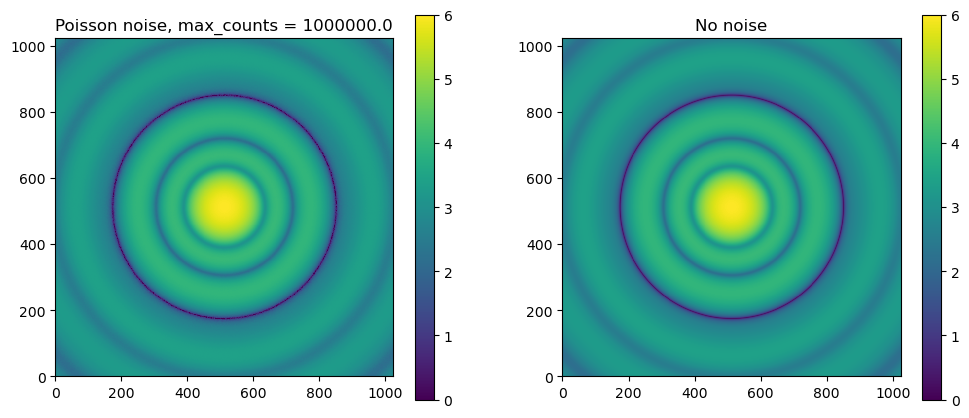

In [16]:
Iscat_n= np.random.poisson(Iscat)
Iscat_n[Iscat_n<1]=1 #get rid of zeros
#and plot to check
fig, ax = plt.subplots(1,2, figsize=(12,5))
p1 = ax[0].pcolormesh(np.log10(Iscat_n))
#ax.pcolor(Iscat)
ax[0].set_aspect('equal')
ax[0].set_title('Poisson noise, max_counts = {}'.format(max_count))
plt.colorbar(p1)
p2 = ax[1].pcolormesh(np.log10(Iscat), vmin=0, vmax= np.log10(max_count))
#ax.pcolor(Iscat)
ax[1].set_aspect('equal')
ax[1].set_title('No noise')
plt.colorbar(p2)
plt.show()

Next I need to make the radial integrals here - do it by hand first and then functionalise it. Easy as I know the centres...

In [17]:
def ring_integral(Iscat, n_rings, ring_coords, centre_coords, pix_size, det_distance):
    #centre_coords in pixels for now, even though it's ugly
    ring_width = ring_coords[1]-ring_coords[0]
    ring_theta = np.arctan((ring_coords+ring_width/2)*pix_size/det_distance)  #need to add half the ring width to make it accurate
    Xm = np.arange(-512, 512)
    xm, ym = np.meshgrid(Xm, Xm)
    rm = np.sqrt((xm-centre_coords[0])**2 + (ym-centre_coords[1])**2)   #pixel number arrays to use
    Irad = np.zeros(ring_coords.shape)
    for ii in range(0,n_rings-1):
        #define the ring
        mask = np.ones(Iscat.shape)
        mask[rm > ring_coords[ii+1]]=0
        mask[rm <= ring_coords[ii]]=0
        Iring = Iscat_n * mask
        Irad[ii] = Iring.sum()/mask.sum()
    Irad[Irad<1]=1; #get rid of zeros again for plot
    return Irad, ring_theta

#now see if it works...
n_rings = 300
ring_coords = np.linspace(0,512, n_rings)
centre_offset = [0,0]
Irad0, th = ring_integral(Iscat_n, n_rings, ring_coords, centre_offset, pix_size, det_distance)
centre_offset2 = [0,5]
Irad1, th = ring_integral(Iscat_n, n_rings, ring_coords, centre_offset2, pix_size, det_distance)
centre_offset3 = [0,10]
Irad2, th = ring_integral(Iscat_n, n_rings, ring_coords, centre_offset3, pix_size, det_distance)
centre_offset4 = [0,15]
Irad3, th = ring_integral(Iscat_n, n_rings, ring_coords, centre_offset4, pix_size, det_distance)
centre_offset5 = [0,20]
Irad4, th = ring_integral(Iscat_n, n_rings, ring_coords, centre_offset5, pix_size, det_distance)

So next I better compare this to the calculated Mie signal, which I shoud be able to get directly from the angle array of the rings.

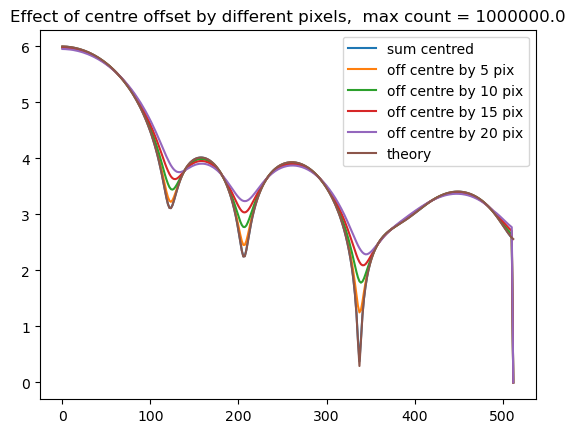

In [18]:
Iscat_theory= mdg.mie_theta(lambda_, th.reshape(1,n_rings), radius, index1, index2)
Iscat_theory = max_count * Iscat_theory/Iscat_theory.max()

fig, ax = plt.subplots()
ax.plot(ring_coords, np.log10(Irad0), label='sum centred')
ax.plot(ring_coords, np.log10(Irad1), label='off centre by {} pix'.format(centre_offset2[1]))
ax.plot(ring_coords, np.log10(Irad2), label='off centre by {} pix'.format(centre_offset3[1]))
ax.plot(ring_coords, np.log10(Irad3), label='off centre by {} pix'.format(centre_offset4[1]))
ax.plot(ring_coords, np.log10(Irad4), label='off centre by {} pix'.format(centre_offset5[1]))
#ax.pcolormesh(mask)
#plt.show()
ax.plot(ring_coords, np.log10(Iscat_theory), label = 'theory')
ax.legend()
ax.set_title('Effect of centre offset by different pixels,  max count = {}'.format(max_count))
plt.show()



### Summary
So, there it is. Looking at the above, the effect of running off-centre isn't large at 5 pix but becoimes significant by 20 pix. this is for 300 rings too, I should note, in 512 pix so the ring width is 1.7 pixels

### Other errors
Not sure what else could be problematic - possibly the places wehre we've filled in the data. Might be able to ignore that if we use a 2D network. 